In [1]:
import pandas as pd
import numpy as np

import polars as pl
from datetime import date

import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, confusion_matrix

from src.feature_engineering import Features 
from src.modelling import fit_pipeline_with_tuning
from src.data_split import train_test_split
from src.plotting import plot_feature_importances, plot_shap, plot_shap_waterfall, plot_shap_bar
from src.explainability import compute_shap

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
target = 'is_on_podium'

categorical_features = [
    'dcat',
    'athlete_id', 
    'athlete_country', 
    'gender'
]

numerical_features = [
    'height',
    'athlete_age_in_days',
    'athlete_years_active',
    'jpn_athletes_count',
    'fra_athletes_count',
    'is_janja_competing',
    'events_last_year',
    'podiums_last_year',
    'finals_last_year',
    'semis_last_year',
    'avg_rank_last_year',
    'progression_to_semi_last_year',
    'progression_to_final_last_year'
]

features = categorical_features + numerical_features

In [3]:
df = pl.read_csv("data/ifsc_boulder_results.csv")

df = Features.add_features(df)

# split data with custom splitting strategy
train_data, test_data = train_test_split(df, test_ratio=0.15)

param_dist = {
    'classifier__n_estimators': [10, 20, 50, 100],
    'classifier__max_depth': [3, 6],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.7, 0.8, 1],
    'preprocessor__cat__min_frequency': [0.05, 0.1],
    'preprocessor__ath__max_categories': [10, 30, 50]
}

model, best_score, best_params = fit_pipeline_with_tuning(
    data=train_data,
    categorical_features=categorical_features,
    numerical_features=numerical_features,
    target=target,
    param_dist=param_dist
)

print(
    "best score:", best_score,
    "\nbest params:", best_params
)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
best score: 0.4214159029495667 
best params: {'preprocessor__cat__min_frequency': 0.05, 'preprocessor__ath__max_categories': 10, 'classifier__subsample': 1, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}


In [4]:
X_train = train_data.select(features)
y_train = train_data.select(target)
X_test = test_data.select(features)
y_test = test_data.select(target)

test_preds = model.predict(X_test)
train_preds = model.predict(X_train)

print(
    "train auc :", roc_auc_score(y_train.to_arrow(), train_preds),
    "\ntest auc:", roc_auc_score(y_test.to_arrow(), test_preds),
    "\n\ntrain accuracy:", accuracy_score(y_train.to_arrow(), train_preds),
    "\ntest accuracy:", accuracy_score(y_test.to_arrow(), test_preds),
    "\n\ntrain avg precision:", average_precision_score(y_train.to_arrow(), train_preds),
    "\ntest avg precision:", average_precision_score(y_test.to_arrow(), test_preds)
)

print("\nconfusion_matrix:\n", confusion_matrix(y_test.to_arrow(), test_preds))

train auc : 0.9429378531073446 
test auc: 0.8912953795379538 

train accuracy: 0.9182706544270062 
test accuracy: 0.9063492063492063 

train avg precision: 0.3114875135722041 
test avg precision: 0.2433982683982684

confusion_matrix:
 [[550  56]
 [  3  21]]


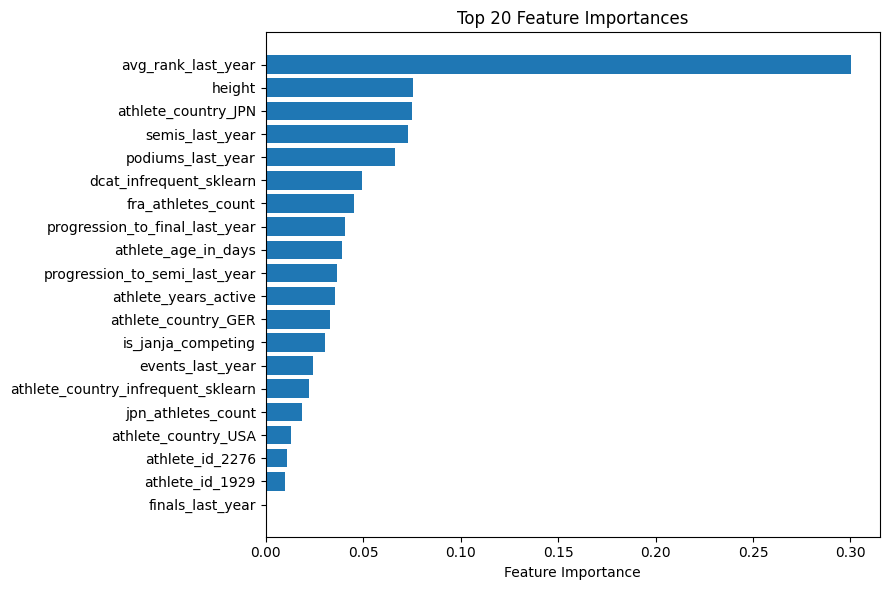

In [5]:
plot_feature_importances(model, top_n=20, save_fig=True)

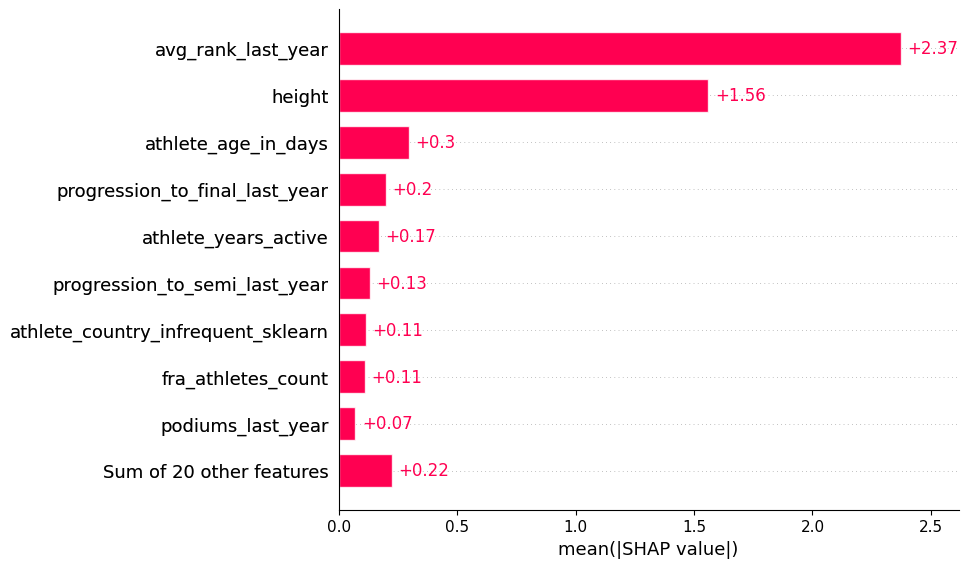

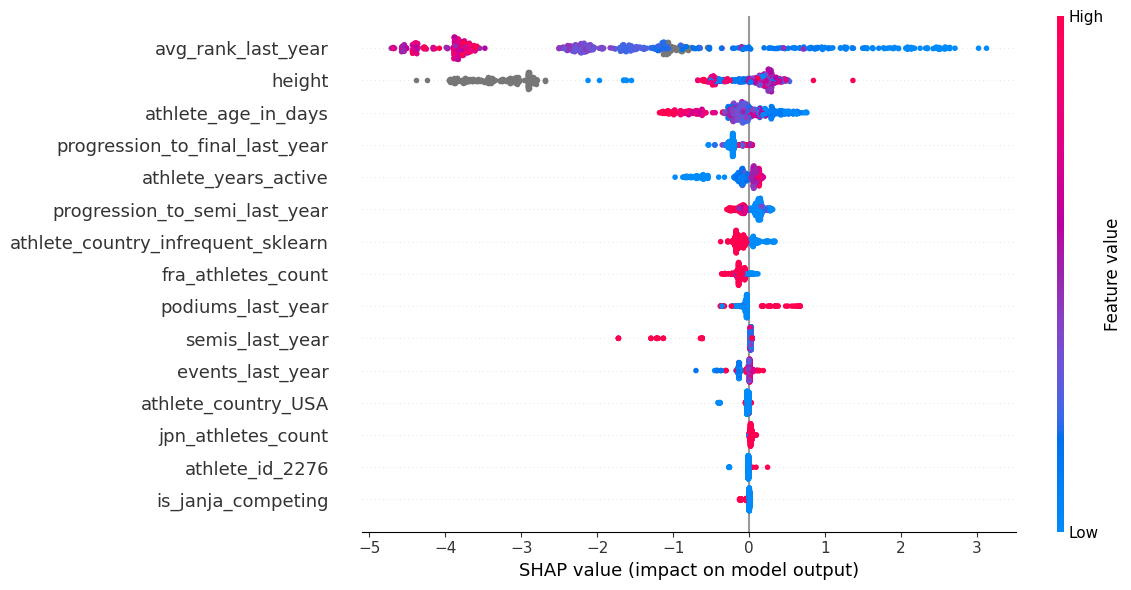

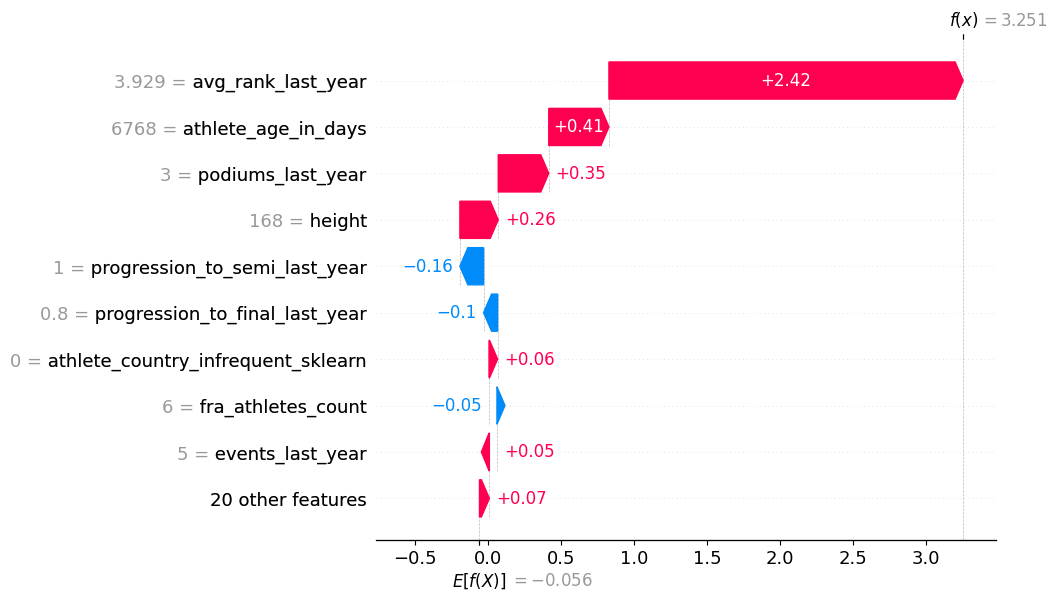

In [6]:
explainer, shap_values = compute_shap(model, X_test)

plot_shap_bar(shap_values, save_path="plots/shap_barplot.png")
plot_shap(model, X_test, top_n=15, shap_values=shap_values, save_path="plots/shap_plot.png")

test_athlete_name = 'sorato'
test_row_index = test_data.with_row_index().filter(pl.col("athlete_name").str.to_lowercase().str.contains(test_athlete_name)).head(1).select('index').item()

plot_shap_waterfall(shap_values, test_row_index, model=model, top_n=10, save_path=f"plots/shap_waterfall_{test_athlete_name}.png")
